Lind para baixar mapas
https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html

In [1]:
#Ler todos os arquivos da pasta 2012
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from io import StringIO
from matplotlib.dates import MonthLocator
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px
import contextily as ctx
import warnings
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

In [2]:
files = glob.glob('C:\\Users\\Daniel\\Desktop\\11-UFMG\\Banco de Dados Geográficos\\TP02-BDG\\Base-de-dados-utilizada\\*.csv')

Foi necessário eliminar as 8 primeiras linhas pois elas continham informações de descrições gerais sobre as estações.
Entretanto cabe salientar que estas informações são cruciais para o desenvolvimento do projeto, como a localização das estações, nome das estações, estado, região e etc.
Sendo assim estas informações foram salvas no dataset criando-se uma coluna para cada informação.

In [3]:
dataframes = []

for file in files:
    with open(file, 'r', encoding='ANSI') as file_content:
        descricoes = file_content.read().splitlines()[:8]

    # Dicionário para armazenar as informações de descrição e incorporar nas colunas
    info_descricoes = {}
    for descricao in descricoes:
        chave, valor = descricao.split(';')
        info_descricoes[chave] = valor

    df_dados = pd.read_csv(file, sep=';', encoding='ANSI', skiprows=8)

    # Preenchendo todas as linhas com as descrições do arquivo
    for chave, valor in info_descricoes.items():
        df_dados[chave] = valor

    dataframes.append(df_dados)

df = pd.concat(dataframes, ignore_index=True)

In [4]:
df.shape

(526176, 28)

In [5]:
df.head()

,DATA (YYYY-MM-DD),HORA (UTC),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),...,"VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,REGIÃO:,UF:,ESTAÇÃO:,CODIGO (WMO):,LATITUDE:,LONGITUDE:,ALTITUDE:,DATA DE FUNDAÇÃO (YYYY-MM-DD):
0,2012-01-01,00:00,0,1012,"1012,1",1012,-9999,"26,1","23,3","26,4",...,"1,8",NaN,NE,PE,RECIFE,A301,"-8,05916666","-34,95944444",10,2004-12-22
1,2012-01-01,01:00,0,"1012,1","1012,2",1012,-9999,"26,3","22,9","26,4",...,2,NaN,NE,PE,RECIFE,A301,"-8,05916666","-34,95944444",10,2004-12-22
2,2012-01-01,02:00,0,"1011,9","1012,2","1011,9",-9999,"25,9","22,2","26,3",...,1,NaN,NE,PE,RECIFE,A301,"-8,05916666","-34,95944444",10,2004-12-22
3,2012-01-01,03:00,0,"1011,5",1012,"1011,5",-9999,"25,7","22,1",26,...,"1,2",NaN,NE,PE,RECIFE,A301,"-8,05916666","-34,95944444",10,2004-12-22
4,2012-01-01,04:00,0,"1011,1","1011,5","1011,1",-9999,"25,7","22,2","25,7",...,"1,2",NaN,NE,PE,RECIFE,A301,"-8,05916666","-34,95944444",10,2004-12-22


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526176 entries, 0 to 526175
Data columns (total 28 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   DATA (YYYY-MM-DD)                                      526176 non-null  object 
 1   HORA (UTC)                                             526176 non-null  object 
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       526176 non-null  object 
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  526176 non-null  object 
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        526176 non-null  object 
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       526176 non-null  object 
 6   RADIACAO GLOBAL (KJ/m²)                                526176 non-null  object 
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           526176 non-null  object 
 8   TEMPERATURA DO PONTO DE ORVALHO (°

In [7]:
# Deletando coluna sem interesse
df.drop(['Unnamed: 19'], axis=1, inplace=True)

Transformação dos dados em tipos corretos, como por exemplo a coluna de data que estava como string e foi transformada em datetime e a coluna de temperatura que estava como string e foi transformada em float.
Foi necessário linhas que continham -99999 para 0 e assim conseguir plotar os dados.
E alterado a vírgula por ponto para que o python reconhecesse os dados como float.

In [8]:
df['LATITUDE:'] = df['LATITUDE:'].str.replace(',', '.').astype(float)
df['LONGITUDE:'] = df['LONGITUDE:'].str.replace(',', '.').astype(float)
df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'] = df['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'] = df['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'] = df['PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['TEMPERATURA DO PONTO DE ORVALHO (°C)'] = df['TEMPERATURA DO PONTO DE ORVALHO (°C)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'] = df['TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'] = df['TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'] = df['TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['RADIACAO GLOBAL (KJ/m²)'] = df['RADIACAO GLOBAL (KJ/m²)'].str.replace(',', '.').replace('-9999', '0').astype(float)
df['DATA (YYYY-MM-DD)'] = pd.to_datetime(df['DATA (YYYY-MM-DD)'], format='%Y-%m-%d')

In [9]:
df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].describe()

count    526176.000000
mean         25.224510
std           6.421157
min           0.000000
25%          22.300000
50%          25.400000
75%          29.300000
max          41.300000
Name: TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C), dtype: float64

<Axes: >

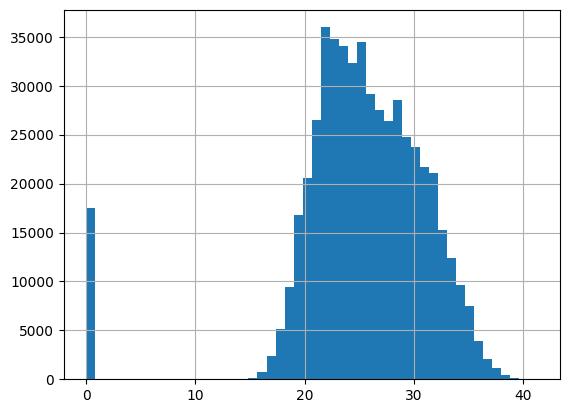

In [10]:
df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].hist(bins=50)

In [11]:
# Filtrar os valores que são nulos
locais_zero_temperatura_maxima = df[df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'] == 0.0]
locais_zero_temperatura_maxima['ESTAÇÃO:'].unique()

array(['RECIFE', 'PETROLINA', 'ARCO VERDE', 'GARANHUNS', 'SURUBIM',
       'CABROBO', 'CARUARU', 'IBIMIRIM', 'SERRA TALHADA', 'FLORESTA',
       'PALMARES', 'OURICURI'], dtype=object)

In [12]:
# Contando os valores nulos da base de dados

tabela_contagem = locais_zero_temperatura_maxima[['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', 'ESTAÇÃO:']].groupby('ESTAÇÃO:').count()

tabela_contagem = tabela_contagem.rename(columns={'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'Contagem de Registros Nulos'})

tabela_contagem

,Contagem de Registros Nulos
ESTAÇÃO:,
ARCO VERDE,1404
CABROBO,1655
CARUARU,1633
FLORESTA,1094
GARANHUNS,2164
IBIMIRIM,244
OURICURI,4771
PALMARES,1140
PETROLINA,26


Vejo que temos um problema de dados faltantes, pois a temperatura máxima não pode ser 0, Iremos excluir esses registros.

In [13]:
# Deletando os valores nulos
df_positivos = df[df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'] > 0].copy()

df_positivos = df_positivos.dropna(subset=['DATA (YYYY-MM-DD)'])

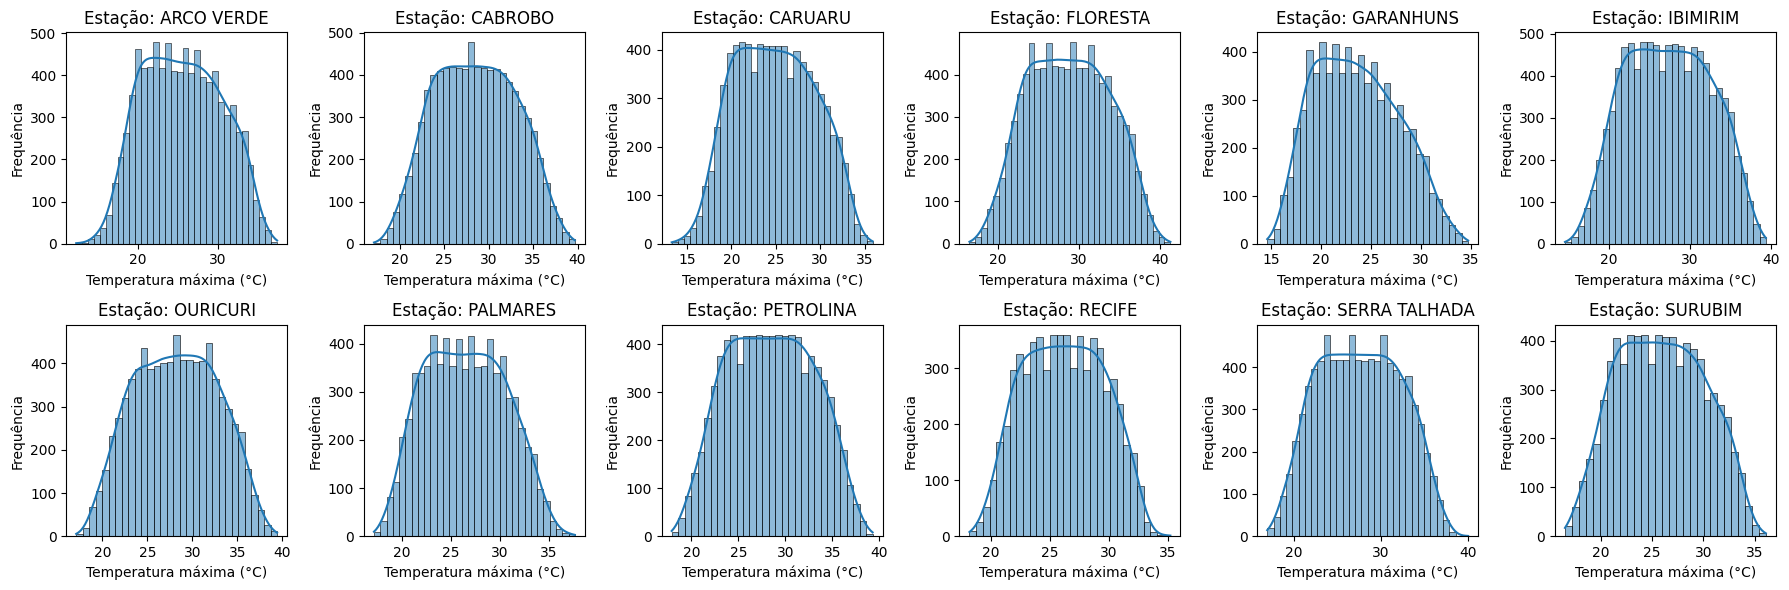

In [14]:
df_positivos['DATA (YYYY-MM-DD)'] = pd.to_datetime(df_positivos['DATA (YYYY-MM-DD)'], errors='coerce')

df_positivos['Month/Year'] = df_positivos['DATA (YYYY-MM-DD)'].dt.to_period('M')

df_contagem_mensal = df_positivos.groupby(['Month/Year', 'ESTAÇÃO:', 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)']).size().reset_index(name='Contagem')

df_contagem_mensal['Month/Year'] = df_contagem_mensal['Month/Year'].dt.strftime('%Y-%m-%d')

# Plotar gráfico de temperatura máxima por estação
plt.figure(figsize=(18, 6))
for i, estação in enumerate(df_contagem_mensal['ESTAÇÃO:'].unique()):
    df_estação = df_contagem_mensal[df_contagem_mensal['ESTAÇÃO:'] == estação]

    plt.subplot(2, 6, i + 1)

    sns.histplot(df_estação['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'], kde=True)

    # Configurar título e rótulos
    plt.title(f'Estação: {estação}')
    plt.xlabel('Temperatura máxima (°C)')
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


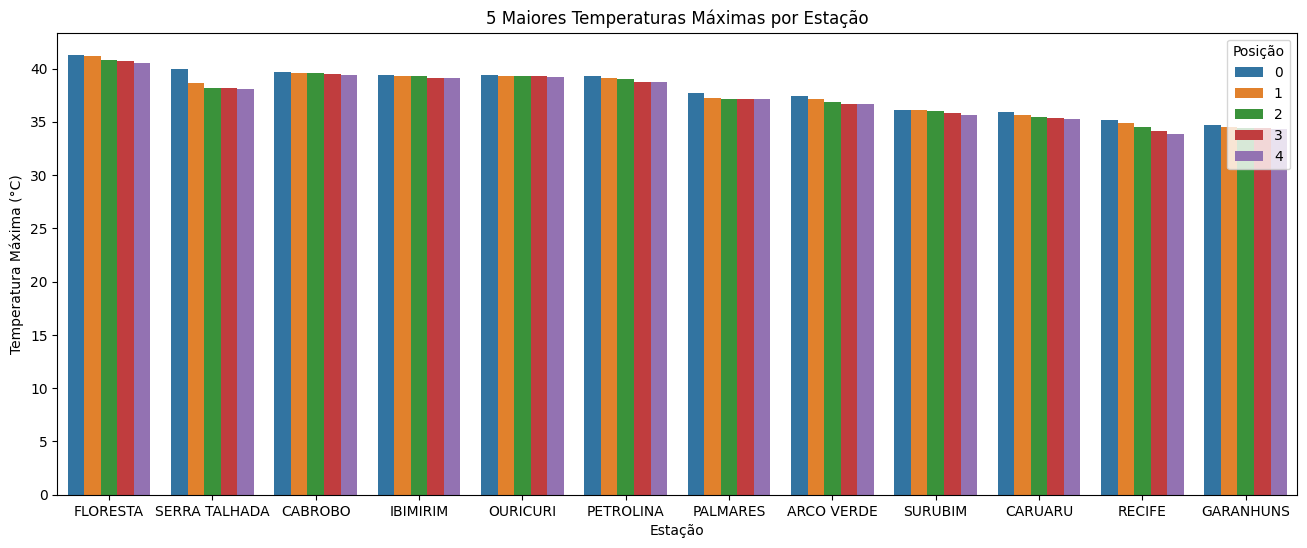

In [15]:
# Agrupar por estação e obter as 5 maiores temperaturas máximas
df_top5_temperaturas = df_positivos.groupby('ESTAÇÃO:')['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].nlargest(5).reset_index().sort_values('TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', ascending=False)


# Criar um gráfico de barras empilhadas com as cores personalizadas
plt.figure(figsize=(16, 6))
sns.barplot(x='ESTAÇÃO:', y='TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', hue=df_top5_temperaturas.groupby('ESTAÇÃO:').cumcount(), data=df_top5_temperaturas)

# Configurar título e rótulos
plt.title('5 Maiores Temperaturas Máximas por Estação')
plt.xlabel('Estação')
plt.ylabel('Temperatura Máxima (°C)')

# Adicionar legenda
plt.legend(title='Posição')

# Mostrar o gráfico
plt.show()


In [16]:
# Criando um gráfico interativo com Plotly Graph Objects
fig = go.Figure()

for i, estacao in enumerate(df_top5_temperaturas['ESTAÇÃO:'].unique()):
    df_estacao = df_top5_temperaturas[df_top5_temperaturas['ESTAÇÃO:'] == estacao]

    fig.add_trace(go.Bar(
        x=[f'{estacao} - {j+1}' for j in range(len(df_estacao))],
        y=df_estacao['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'],
        name=f'{estacao}',
        hovertemplate='Estação: ' + estacao + '<br>' +
                      'Temperatura Máxima: %{y}°C',
    ))

# Atualizar layout do gráfico
fig.update_layout(
    barmode='stack',
    title='5 Maiores Temperaturas Máximas por Estação',
    xaxis_title='Estação',
    yaxis_title='Temperatura Máxima (°C)',
    legend_title='Posição',
    hovermode='closest',
    height=600,
    width=1200
)

fig.show()


In [17]:
# Uma outra possibilidade de gráfico interativo com Plotly Graph Objects
fig = go.Figure()

for i, estacao in enumerate(df_top5_temperaturas['ESTAÇÃO:'].unique()):
    df_estacao = df_top5_temperaturas[df_top5_temperaturas['ESTAÇÃO:'] == estacao]

    fig.add_trace(go.Bar(
        x=[f'{estacao}' for _ in range(len(df_estacao))],
        y=df_estacao['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'],
        name=f'{estacao}',
        text=[f'{estacao} - Posição {j+1}<br>Temperatura Máxima: {temp}°C' for j, temp in enumerate(df_estacao['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'])],
        hoverinfo='text',
    ))

# Atualizar layout do gráfico
fig.update_layout(
    barmode='stack',
    title='5 Maiores Temperaturas Máximas por Estação',
    xaxis_title='Estação',
    yaxis_title='Temperatura Máxima (°C)',
    legend_title='Posição',
    hovermode='closest'
)

# Mostrar o gráfico
fig.show()


In [18]:
import plotly.express as px

# Supondo que 'df_positivos' seja o DataFrame
# Se necessário, importe pandas e ajuste 'df_positivos' de acordo com o seu DataFrame

# Agrupar por média mensal e por estação
df_mensal = df_positivos.groupby(['Month/Year', 'ESTAÇÃO:']).max().reset_index()

# Mapear os períodos para descrições no formato "01-12", "02-12", ...
df_mensal['Month/Year'] = df_mensal['Month/Year'].dt.strftime('%Y-%m-%d')

# Criar um gráfico interativo com o Plotly Express
fig = px.line(df_mensal, x='Month/Year', y='TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', color='ESTAÇÃO:', markers=True)

# Adicionar interatividade para destacar a linha e mostrar os valores ao passar o mouse
fig.update_traces(mode='markers+lines', hovertemplate=None)
fig.update_layout(hovermode='x', hoverlabel=dict(bgcolor="white", font_size=16, font_family="Rockwell"))

# Configurações do gráfico
fig.update_layout(
    xaxis=dict(tickangle=-45),
    title='Temperatura máxima mensal por Estação',
    xaxis_title='Mês/Ano',
    yaxis_title='TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
    legend=dict(title='ESTAÇÃO:', orientation="v", x=1.02, y=0.5),  # Ajuste aqui
    width=1200,
    height=700,
)

# Exibir o gráfico interativo
fig.show()


## Visualizações dos mapas
- Pontos dos medidores no mapa de Pernambuco
- Mostrar nos mapas as temperaturas no meio de cada estação, com cores diferentes para cada estação

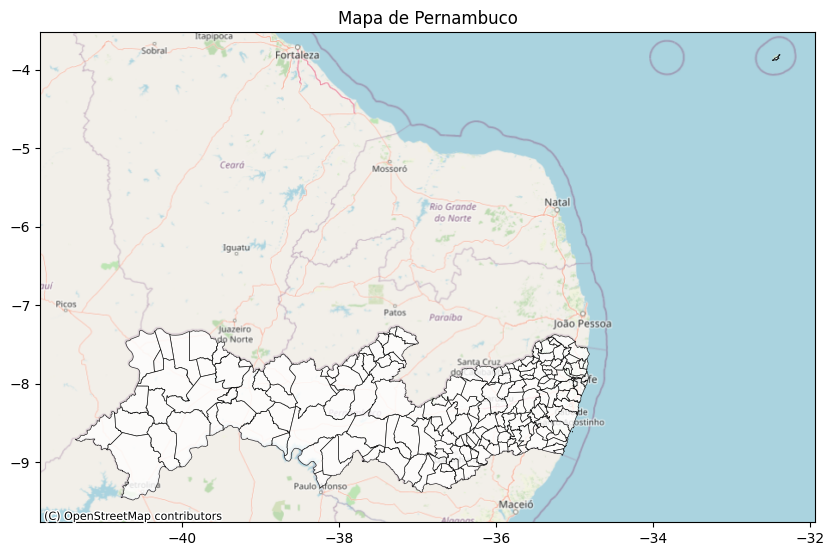

In [19]:
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
# Carregando o arquivo de dados do mapa de Pernambuco do IBGE
mapa_pernambuco = gpd.read_file("./mapa/PE_Mnunicipios_2022/PE_Municipios_2022.shp")

# Configurações para melhorar a apresentação do mapa
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Mapa de Pernambuco")
mapa_pernambuco.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.8, color='white')

# Adicionar fundo de mapa do OpenStreetMap usando contextily
ctx.add_basemap(ax, crs=mapa_pernambuco.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)

# Mostrar o mapa
plt.show()

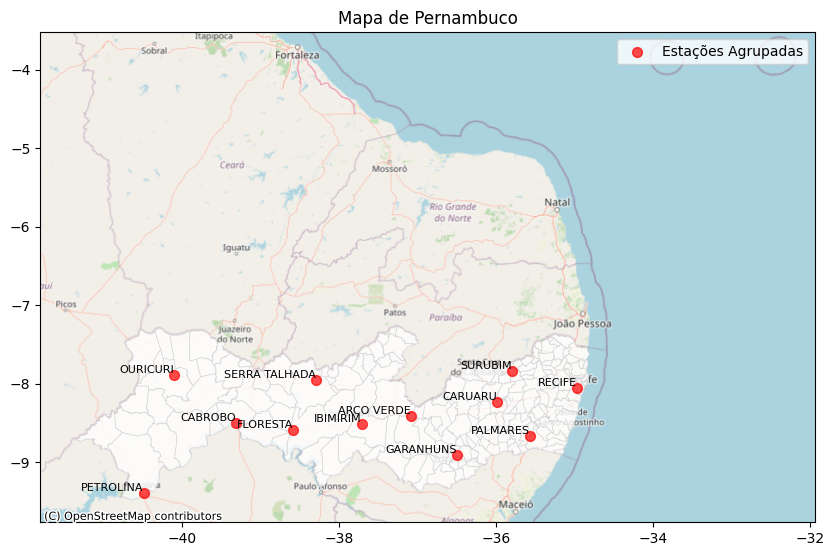

In [20]:
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
nomes_estacoes = df['ESTAÇÃO:'].unique()

# Criando um dataframe que contém as coordenadas médias de cada estação
coordenadas_estacoes = []
for estacao in nomes_estacoes:
    estacao_data = df[df['ESTAÇÃO:'] == estacao]
    
    if not estacao_data.empty:
        media_latitude = estacao_data['LATITUDE:'].mean()
        media_longitude = estacao_data['LONGITUDE:'].mean()
        coordenadas_estacoes.append({'Estacao': estacao, 'Latitude': media_latitude, 'Longitude': media_longitude})

# Condicional para ver se existem estações
if coordenadas_estacoes:
    df_estacoes_agrupadas = pd.DataFrame(coordenadas_estacoes)

    # Convertendo o DataFrame de estações para um GeoDataFrame
    gdf_estacoes_agrupado = gpd.GeoDataFrame(df_estacoes_agrupadas,
                                              geometry=gpd.points_from_xy(df_estacoes_agrupadas['Longitude'], df_estacoes_agrupadas['Latitude']),
                                              crs='EPSG:4326')

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Mapa de Pernambuco")

    mapa_pernambuco.plot(ax=ax, edgecolor='#D3D3D3', linewidth=0.5, alpha=0.8, color='white')

    ctx.add_basemap(ax, crs=mapa_pernambuco.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)

    # Plotando os pontos das estações
    gdf_estacoes_agrupado.plot(ax=ax, marker='o', color='red', markersize=50, label='Estações Agrupadas', alpha=0.7)
    # Adicionar o nome de cada estação no mapa
    for idx, row in gdf_estacoes_agrupado.iterrows():
        ax.text(row['Longitude'], row['Latitude'], row['Estacao'], fontsize=8, ha='right', va='bottom', color='black')

    plt.legend()
    plt.show()


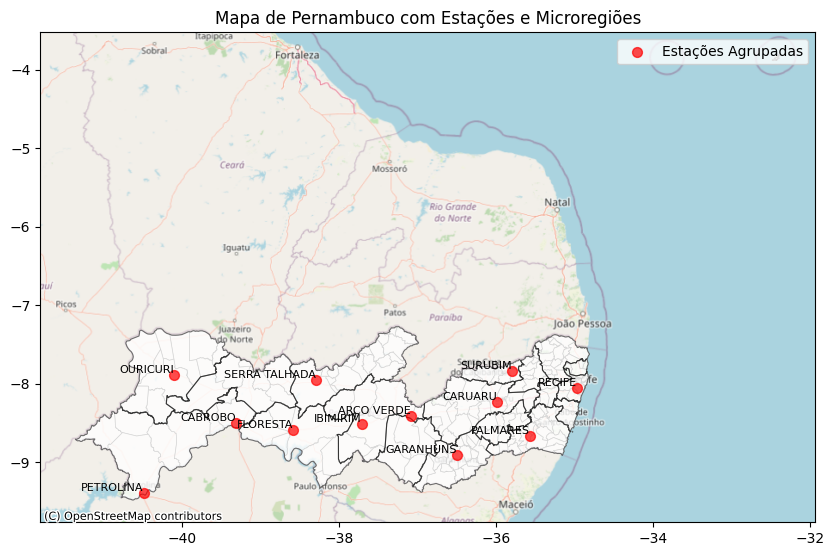

In [21]:
coordenadas_estacoes = []
for estacao in nomes_estacoes:
    estacao_data = df[df['ESTAÇÃO:'] == estacao]
    
    if not estacao_data.empty:
        media_latitude = estacao_data['LATITUDE:'].mean()
        media_longitude = estacao_data['LONGITUDE:'].mean()
        coordenadas_estacoes.append({'Estacao': estacao, 'Latitude': media_latitude, 'Longitude': media_longitude})

if coordenadas_estacoes:
    df_estacoes_agrupadas = pd.DataFrame(coordenadas_estacoes)

    gdf_estacoes_agrupado = gpd.GeoDataFrame(df_estacoes_agrupadas,
                                              geometry=gpd.points_from_xy(df_estacoes_agrupadas['Longitude'], df_estacoes_agrupadas['Latitude']),
                                              crs='EPSG:4326')

    # Carregando o mapa das microregiões de pernambuco
    mapa_microregioes = gpd.read_file("./mapa/PE_Microrregioes_2022/PE_Microrregioes_2022.shp")

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Mapa de Pernambuco com Estações e Microregiões")

    mapa_pernambuco.plot(ax=ax, edgecolor='#D3D3D3', linewidth=0.5, alpha=0.8, color='white')

    ctx.add_basemap(ax, crs=mapa_pernambuco.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)

    mapa_microregioes.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.5, facecolor='none')

    gdf_estacoes_agrupado.plot(ax=ax, marker='o', color='red', markersize=50, label='Estações Agrupadas', alpha=0.7)

    # Adicionar o nome de cada estação no mapa
    for idx, row in gdf_estacoes_agrupado.iterrows():
        ax.text(row['Longitude'], row['Latitude'], row['Estacao'], fontsize=8, ha='right', va='bottom', color='black')

    # Mostrar o mapa
    plt.legend()
    plt.show()


In [22]:
nomes_estacoes = df['ESTAÇÃO:'].unique()

# Criando uma tabela para conter temperaturas máximas das estações durante o período dos dados
tabela_temperatura_maxima = pd.pivot_table(df, values='TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', index='ESTAÇÃO:', aggfunc='max')

print(tabela_temperatura_maxima)

               TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)
ESTAÇÃO:                                                 
ARCO VERDE                                           37.4
CABROBO                                              39.7
CARUARU                                              35.9
FLORESTA                                             41.3
GARANHUNS                                            34.7
IBIMIRIM                                             39.4
OURICURI                                             39.4
PALMARES                                             37.7
PETROLINA                                            39.3
RECIFE                                               35.2
SERRA TALHADA                                        40.0
SURUBIM                                              36.1


Criando um novo dataframe a fim de preencher de cor as microrregiões de Pernambuco, com base na temperatura máxima de cada microrregião.
Onde estiver estações.

In [23]:
# Selecionar colunas relevantes do DataFrame df
dados_estacoes = df[['ESTAÇÃO:', 'LATITUDE:', 'LONGITUDE:']].drop_duplicates()

tabela_temperatura_maxima = pd.pivot_table(df, values='TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', index='ESTAÇÃO:', aggfunc='max')

tabela_temperatura_maxima = tabela_temperatura_maxima.rename(columns={'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'Temperatura Máxima'})

dados_estacoes = pd.merge(dados_estacoes, tabela_temperatura_maxima, left_on='ESTAÇÃO:', right_index=True, how='left')

dados_estacoes


,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima
0,RECIFE,-8.059167,-34.959444,35.2
43848,PETROLINA,-9.388056,-40.489444,39.3
87696,ARCO VERDE,-8.416944,-37.083333,37.4
131544,GARANHUNS,-8.906944,-36.494722,34.7
175392,SURUBIM,-7.836944,-35.796111,36.1
219240,CABROBO,-8.503056,-39.313889,39.7
263088,CARUARU,-8.236111,-35.985833,35.9
306936,IBIMIRIM,-8.509444,-37.711389,39.4
350784,SERRA TALHADA,-7.953611,-38.294722,40.0
394632,FLORESTA,-8.593611,-38.583889,41.3


Relacionando cada estação com a microrregião que ela está localizada.

In [24]:
# Criando um GeoDataFrame a partir dos dados das estações
gdf_estacoes = gpd.GeoDataFrame(dados_estacoes, geometry=gpd.points_from_xy(dados_estacoes['LONGITUDE:'], dados_estacoes['LATITUDE:']))

# Criando um DataFrame para armazenar as informações de estação por microregião
estacoes_por_microregiao = pd.DataFrame(columns=['Microregiao'])

# Verificar se as estações estão contindas em alguma microregião
for idx, microregiao in mapa_microregioes.iterrows():
    microregiao_geom = microregiao['geometry']
    estacoes_na_microregiao = gdf_estacoes[gdf_estacoes['geometry'].within(microregiao_geom)]
    
    # Adicionar informações ao DataFrame estacoes_por_microregiao
    estacoes_por_microregiao = pd.concat([
        estacoes_por_microregiao,
        estacoes_na_microregiao[['ESTAÇÃO:', 'LATITUDE:', 'LONGITUDE:', 'Temperatura Máxima']].assign(Microregiao=microregiao['NM_MICRO'])
    ], ignore_index=True)

estacoes_por_microregiao


,Microregiao,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima
0,Araripina,OURICURI,-7.884722,-40.101111,39.4
1,Pajeú,SERRA TALHADA,-7.953611,-38.294722,40.0
2,Sertão do Moxotó,ARCO VERDE,-8.416944,-37.083333,37.4
3,Sertão do Moxotó,IBIMIRIM,-8.509444,-37.711389,39.4
4,Petrolina,PETROLINA,-9.388056,-40.489444,39.3
5,Petrolina,CABROBO,-8.503056,-39.313889,39.7
6,Itaparica,FLORESTA,-8.593611,-38.583889,41.3
7,Vale do Ipojuca,CARUARU,-8.236111,-35.985833,35.9
8,Alto Capibaribe,SURUBIM,-7.836944,-35.796111,36.1
9,Garanhuns,GARANHUNS,-8.906944,-36.494722,34.7


In [25]:
gdf_estacoes_por_microregiao = pd.merge(estacoes_por_microregiao, mapa_microregioes[['NM_MICRO', 'geometry']], left_on='Microregiao', right_on='NM_MICRO')

# Criar um novo GeoDataFrame usando a geometria da microregião
gdf_estacoes_por_microregiao = gpd.GeoDataFrame(gdf_estacoes_por_microregiao, geometry='geometry', crs=mapa_microregioes.crs)

gdf_estacoes_por_microregiao

,Microregiao,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima,NM_MICRO,geometry
0,Araripina,OURICURI,-7.884722,-40.101111,39.4,Araripina,"POLYGON ((-40.56066 -7.99729, -40.55412 -7.983..."
1,Pajeú,SERRA TALHADA,-7.953611,-38.294722,40.0,Pajeú,"POLYGON ((-37.17067 -7.80023, -37.17067 -7.800..."
2,Sertão do Moxotó,ARCO VERDE,-8.416944,-37.083333,37.4,Sertão do Moxotó,"POLYGON ((-37.78771 -8.41351, -37.79862 -8.420..."
3,Sertão do Moxotó,IBIMIRIM,-8.509444,-37.711389,39.4,Sertão do Moxotó,"POLYGON ((-37.78771 -8.41351, -37.79862 -8.420..."
4,Petrolina,PETROLINA,-9.388056,-40.489444,39.3,Petrolina,"POLYGON ((-40.19621 -8.51168, -40.19615 -8.511..."
5,Petrolina,CABROBO,-8.503056,-39.313889,39.7,Petrolina,"POLYGON ((-40.19621 -8.51168, -40.19615 -8.511..."
6,Itaparica,FLORESTA,-8.593611,-38.583889,41.3,Itaparica,"POLYGON ((-38.31287 -9.14837, -38.31594 -9.144..."
7,Vale do Ipojuca,CARUARU,-8.236111,-35.985833,35.9,Vale do Ipojuca,"POLYGON ((-36.44375 -7.92026, -36.43999 -7.920..."
8,Alto Capibaribe,SURUBIM,-7.836944,-35.796111,36.1,Alto Capibaribe,"POLYGON ((-35.70798 -7.83140, -35.70784 -7.831..."
9,Garanhuns,GARANHUNS,-8.906944,-36.494722,34.7,Garanhuns,"POLYGON ((-36.11150 -9.01767, -36.11150 -9.017..."


In [26]:
# Filtrando os dados para obter apenas as temperaturas máximas de cada mesorregião
indices_max_temps_micro = gdf_estacoes_por_microregiao.groupby('NM_MICRO')['Temperatura Máxima'].idxmax()

# Criando um DataFrame com os índices encontrados
gdf_temps_maximas_microregioes = gdf_estacoes_por_microregiao.loc[indices_max_temps_micro].copy()

gdf_temps_maximas_microregioes

,Microregiao,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima,NM_MICRO,geometry
8,Alto Capibaribe,SURUBIM,-7.836944,-35.796111,36.1,Alto Capibaribe,"POLYGON ((-35.70798 -7.83140, -35.70784 -7.831..."
0,Araripina,OURICURI,-7.884722,-40.101111,39.4,Araripina,"POLYGON ((-40.56066 -7.99729, -40.55412 -7.983..."
9,Garanhuns,GARANHUNS,-8.906944,-36.494722,34.7,Garanhuns,"POLYGON ((-36.11150 -9.01767, -36.11150 -9.017..."
6,Itaparica,FLORESTA,-8.593611,-38.583889,41.3,Itaparica,"POLYGON ((-38.31287 -9.14837, -38.31594 -9.144..."
10,Mata Meridional Pernambucana,PALMARES,-8.666389,-35.568056,37.7,Mata Meridional Pernambucana,"MULTIPOLYGON (((-35.08779 -8.69077, -35.09033 ..."
1,Pajeú,SERRA TALHADA,-7.953611,-38.294722,40.0,Pajeú,"POLYGON ((-37.17067 -7.80023, -37.17067 -7.800..."
5,Petrolina,CABROBO,-8.503056,-39.313889,39.7,Petrolina,"POLYGON ((-40.19621 -8.51168, -40.19615 -8.511..."
11,Recife,RECIFE,-8.059167,-34.959444,35.2,Recife,"POLYGON ((-35.03101 -7.92977, -35.03179 -7.928..."
3,Sertão do Moxotó,IBIMIRIM,-8.509444,-37.711389,39.4,Sertão do Moxotó,"POLYGON ((-37.78771 -8.41351, -37.79862 -8.420..."
7,Vale do Ipojuca,CARUARU,-8.236111,-35.985833,35.9,Vale do Ipojuca,"POLYGON ((-36.44375 -7.92026, -36.43999 -7.920..."


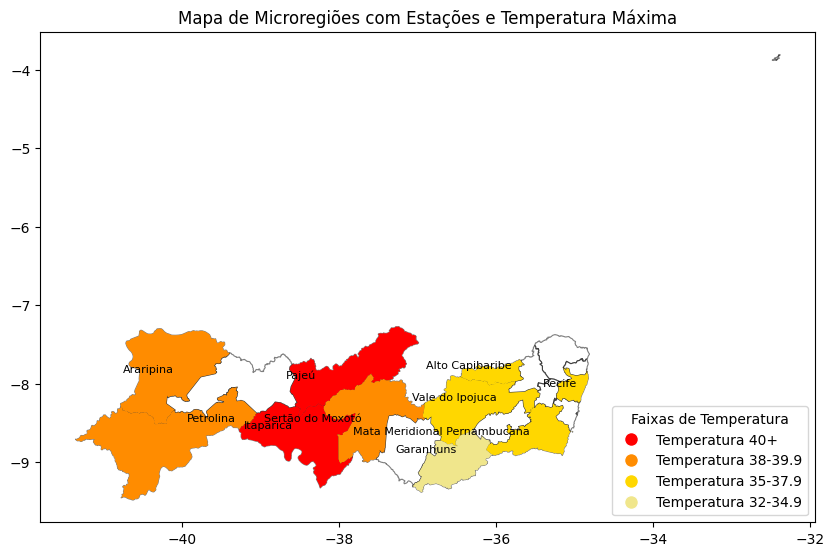

In [42]:
# Configurações para melhorar a apresentação do mapa
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Mapa de Microregiões com Estações e Temperatura Máxima")

mapa_microregioes.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.5, facecolor='none')

# Definir cores com base nas faixas de temperatura
colors = {'40+': 'red', '38-39.9': 'darkorange', '35-37.9': 'gold', '32-34.9': 'khaki'}

# Lista para armazenar objetos de pontos (para a legenda)
scatter_list = []

# Plotar os pontos das estações com base na geometria e na faixa de temperatura
for faixa, color in colors.items():
    if '+' in faixa:
        temp_subset = gdf_temps_maximas_microregioes[gdf_temps_maximas_microregioes['Temperatura Máxima'] >= float(faixa.replace('+', ''))]
    else:
        temp_range = list(map(float, faixa.split('-')))
        temp_subset = gdf_temps_maximas_microregioes[
            (gdf_temps_maximas_microregioes['Temperatura Máxima'] >= temp_range[0]) &
            (gdf_temps_maximas_microregioes['Temperatura Máxima'] <= temp_range[1])
        ]

    scatter = temp_subset.plot(ax=ax, color=color, markersize=50, label=f'Temperatura {faixa}', zorder=2)
    scatter_list.append(scatter)

# Adicionar rótulos para as estações
for idx, row in gdf_temps_maximas_microregioes.iterrows():
    ax.text(row['LONGITUDE:'], row['LATITUDE:'], row['Microregiao'], fontsize=8, ha='right', va='bottom', color='black', zorder=3)

# Adicionar legenda com cores
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Temperatura {faixa}') for faixa, color in colors.items()]
ax.legend(handles=legend_elements, title='Faixas de Temperatura', loc='lower right')

# Mostrar o mapa
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


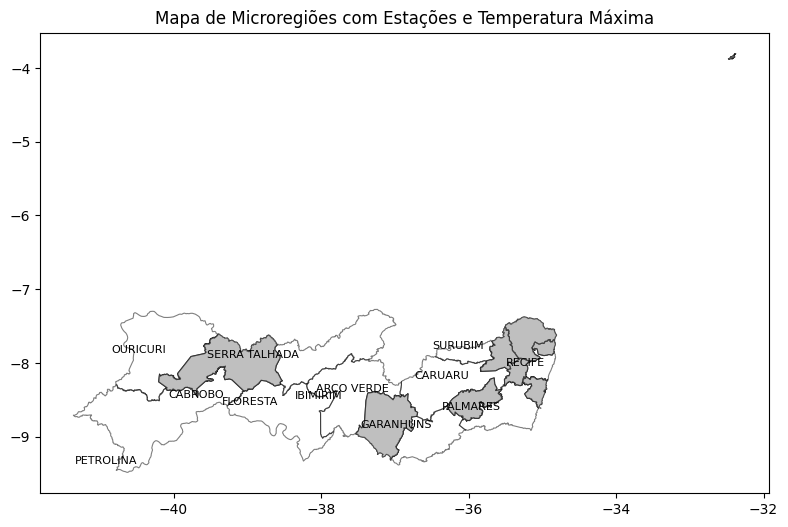

In [28]:
# Identificando as microregiões sem estações
microregioes_sem_estacoes = mapa_microregioes[~mapa_microregioes['NM_MICRO'].isin(gdf_estacoes_por_microregiao['Microregiao'])]

# Adicionando essas microregiões ao GeoDataFrame mapa_microregioes
mapa_microregioes_com_sem_estacoes = pd.concat([mapa_microregioes, microregioes_sem_estacoes])

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Mapa de Microregiões com Estações e Temperatura Máxima")

mapa_microregioes_com_sem_estacoes.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.5, facecolor='none')

microregioes_sem_estacoes.plot(ax=ax, color='gray', alpha=0.5)

for idx, row in gdf_estacoes_por_microregiao.iterrows():
    ax.text(row['LONGITUDE:'], row['LATITUDE:'], row['ESTAÇÃO:'], fontsize=8, ha='right', va='bottom', color='black', zorder=3)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.set_visible(False)  # Esconder a barra de cores para a função scatter

# Mostrar o mapa
plt.legend()
plt.show()


In [29]:
df['ANO'] = pd.to_datetime(df['DATA (YYYY-MM-DD)']).dt.year

# Criar uma tabela dinâmica (pivot table) para mostrar as maiores temperaturas para cada estação em cada ano
tabela_temperaturas = df.pivot_table(values='TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
                                     index='ESTAÇÃO:',
                                     columns='ANO',
                                     aggfunc='max').reset_index()

# Adicionar as colunas 'LATITUDE:' e 'LONGITUDE:' à tabela
tabela_temperaturas[['LATITUDE:', 'LONGITUDE:']] = df.groupby('ESTAÇÃO:')[['LATITUDE:', 'LONGITUDE:']].first().reset_index(drop=True)

# Renomear as colunas para incluir o prefixo 'df_'
tabela_temperaturas.columns = [col if col in ['ESTAÇÃO:', 'LATITUDE:', 'LONGITUDE:'] else f'df_{col}' for col in tabela_temperaturas.columns]

tabela_temperatura_maxima = pd.pivot_table(df, values='TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', index='ESTAÇÃO:', aggfunc='max')

# Renomeie a coluna para evitar conflitos durante a junção
tabela_temperatura_maxima = tabela_temperatura_maxima.rename(columns={'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'Temperatura Máxima'})

# Junte a tabela de temperatura máxima com as informações das estações
tabela_temperaturas = pd.merge(tabela_temperaturas, tabela_temperatura_maxima, left_on='ESTAÇÃO:', right_index=True, how='left')

# Exibir ou acessar o DataFrame mestre
print("DataFrame Mestre:")
tabela_temperaturas


DataFrame Mestre:


,ESTAÇÃO:,df_2012,df_2013,df_2014,df_2015,df_2016,LATITUDE:,LONGITUDE:,Temperatura Máxima
0,ARCO VERDE,36.4,36.6,36.0,37.1,37.4,-8.416944,-37.083333,37.4
1,CABROBO,38.3,39.2,38.1,39.7,38.9,-8.503056,-39.313889,39.7
2,CARUARU,34.7,35.3,33.9,35.9,34.8,-8.236111,-35.985833,35.9
3,FLORESTA,39.5,41.2,38.9,41.3,40.5,-8.593611,-38.583889,41.3
4,GARANHUNS,33.4,33.9,32.6,34.7,34.5,-8.906944,-36.494722,34.7
5,IBIMIRIM,38.7,38.7,38.2,39.3,39.4,-8.509444,-37.711389,39.4
6,OURICURI,38.6,38.1,37.8,39.4,39.0,-7.884722,-40.101111,39.4
7,PALMARES,37.7,36.5,34.7,37.2,37.0,-8.666389,-35.568056,37.7
8,PETROLINA,38.0,39.1,38.5,38.6,39.3,-9.388056,-40.489444,39.3
9,RECIFE,34.5,34.1,35.2,33.9,33.8,-8.059167,-34.959444,35.2


In [30]:
# Criar um GeoDataFrame a partir dos dados das estações
gdf_estacoes = gpd.GeoDataFrame(tabela_temperaturas, geometry=gpd.points_from_xy(tabela_temperaturas['LONGITUDE:'], tabela_temperaturas['LATITUDE:']))

# Criar um DataFrame para armazenar as informações de estação por microregião
estacoes_por_microregiao = pd.DataFrame(columns=['Microregiao'])

# Iterar sobre as microregiões e verificar se cada estação está contida nelas
for idx, microregiao in mapa_microregioes.iterrows():
    microregiao_geom = microregiao['geometry']
    estacoes_na_microregiao = gdf_estacoes[gdf_estacoes['geometry'].within(microregiao_geom)]
    
    # Adicionar informações ao DataFrame estacoes_por_microregiao
    estacoes_por_microregiao = pd.concat([
        estacoes_por_microregiao,
        estacoes_na_microregiao[['ESTAÇÃO:', 'LATITUDE:', 'LONGITUDE:', 'Temperatura Máxima', 'df_2012','df_2013','df_2014','df_2015','df_2016' ]].assign(Microregiao=microregiao['NM_MICRO'])
    ], ignore_index=True)

# Exibir o DataFrame estacoes_por_microregiao
estacoes_por_microregiao

,Microregiao,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima,df_2012,df_2013,df_2014,df_2015,df_2016
0,Araripina,OURICURI,-7.884722,-40.101111,39.4,38.6,38.1,37.8,39.4,39.0
1,Pajeú,SERRA TALHADA,-7.953611,-38.294722,40.0,37.8,40.0,37.1,38.6,38.0
2,Sertão do Moxotó,ARCO VERDE,-8.416944,-37.083333,37.4,36.4,36.6,36.0,37.1,37.4
3,Sertão do Moxotó,IBIMIRIM,-8.509444,-37.711389,39.4,38.7,38.7,38.2,39.3,39.4
4,Petrolina,CABROBO,-8.503056,-39.313889,39.7,38.3,39.2,38.1,39.7,38.9
5,Petrolina,PETROLINA,-9.388056,-40.489444,39.3,38.0,39.1,38.5,38.6,39.3
6,Itaparica,FLORESTA,-8.593611,-38.583889,41.3,39.5,41.2,38.9,41.3,40.5
7,Vale do Ipojuca,CARUARU,-8.236111,-35.985833,35.9,34.7,35.3,33.9,35.9,34.8
8,Alto Capibaribe,SURUBIM,-7.836944,-35.796111,36.1,34.3,35.8,34.5,36.1,35.1
9,Garanhuns,GARANHUNS,-8.906944,-36.494722,34.7,33.4,33.9,32.6,34.7,34.5


In [31]:
gdf_estacoes_por_microregiao = pd.merge(estacoes_por_microregiao, mapa_microregioes[['NM_MICRO', 'geometry']], left_on='Microregiao', right_on='NM_MICRO')

# Criar um novo GeoDataFrame usando a geometria da microregião
gdf_estacoes_por_microregiao = gpd.GeoDataFrame(gdf_estacoes_por_microregiao, geometry='geometry', crs=mapa_microregioes.crs)

gdf_estacoes_por_microregiao

,Microregiao,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima,df_2012,df_2013,df_2014,df_2015,df_2016,NM_MICRO,geometry
0,Araripina,OURICURI,-7.884722,-40.101111,39.4,38.6,38.1,37.8,39.4,39.0,Araripina,"POLYGON ((-40.56066 -7.99729, -40.55412 -7.983..."
1,Pajeú,SERRA TALHADA,-7.953611,-38.294722,40.0,37.8,40.0,37.1,38.6,38.0,Pajeú,"POLYGON ((-37.17067 -7.80023, -37.17067 -7.800..."
2,Sertão do Moxotó,ARCO VERDE,-8.416944,-37.083333,37.4,36.4,36.6,36.0,37.1,37.4,Sertão do Moxotó,"POLYGON ((-37.78771 -8.41351, -37.79862 -8.420..."
3,Sertão do Moxotó,IBIMIRIM,-8.509444,-37.711389,39.4,38.7,38.7,38.2,39.3,39.4,Sertão do Moxotó,"POLYGON ((-37.78771 -8.41351, -37.79862 -8.420..."
4,Petrolina,CABROBO,-8.503056,-39.313889,39.7,38.3,39.2,38.1,39.7,38.9,Petrolina,"POLYGON ((-40.19621 -8.51168, -40.19615 -8.511..."
5,Petrolina,PETROLINA,-9.388056,-40.489444,39.3,38.0,39.1,38.5,38.6,39.3,Petrolina,"POLYGON ((-40.19621 -8.51168, -40.19615 -8.511..."
6,Itaparica,FLORESTA,-8.593611,-38.583889,41.3,39.5,41.2,38.9,41.3,40.5,Itaparica,"POLYGON ((-38.31287 -9.14837, -38.31594 -9.144..."
7,Vale do Ipojuca,CARUARU,-8.236111,-35.985833,35.9,34.7,35.3,33.9,35.9,34.8,Vale do Ipojuca,"POLYGON ((-36.44375 -7.92026, -36.43999 -7.920..."
8,Alto Capibaribe,SURUBIM,-7.836944,-35.796111,36.1,34.3,35.8,34.5,36.1,35.1,Alto Capibaribe,"POLYGON ((-35.70798 -7.83140, -35.70784 -7.831..."
9,Garanhuns,GARANHUNS,-8.906944,-36.494722,34.7,33.4,33.9,32.6,34.7,34.5,Garanhuns,"POLYGON ((-36.11150 -9.01767, -36.11150 -9.017..."


In [32]:
# Filtrando os dados para obter apenas as temperaturas máximas de cada mesorregião
indices_max_temps_micro = gdf_estacoes_por_microregiao.groupby('NM_MICRO')['Temperatura Máxima'].idxmax()

# Criando um DataFrame com os índices encontrados
gdf_temps_maximas_microregioes = gdf_estacoes_por_microregiao.loc[indices_max_temps_micro].copy()

gdf_temps_maximas_microregioes

,Microregiao,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima,df_2012,df_2013,df_2014,df_2015,df_2016,NM_MICRO,geometry
8,Alto Capibaribe,SURUBIM,-7.836944,-35.796111,36.1,34.3,35.8,34.5,36.1,35.1,Alto Capibaribe,"POLYGON ((-35.70798 -7.83140, -35.70784 -7.831..."
0,Araripina,OURICURI,-7.884722,-40.101111,39.4,38.6,38.1,37.8,39.4,39.0,Araripina,"POLYGON ((-40.56066 -7.99729, -40.55412 -7.983..."
9,Garanhuns,GARANHUNS,-8.906944,-36.494722,34.7,33.4,33.9,32.6,34.7,34.5,Garanhuns,"POLYGON ((-36.11150 -9.01767, -36.11150 -9.017..."
6,Itaparica,FLORESTA,-8.593611,-38.583889,41.3,39.5,41.2,38.9,41.3,40.5,Itaparica,"POLYGON ((-38.31287 -9.14837, -38.31594 -9.144..."
10,Mata Meridional Pernambucana,PALMARES,-8.666389,-35.568056,37.7,37.7,36.5,34.7,37.2,37.0,Mata Meridional Pernambucana,"MULTIPOLYGON (((-35.08779 -8.69077, -35.09033 ..."
1,Pajeú,SERRA TALHADA,-7.953611,-38.294722,40.0,37.8,40.0,37.1,38.6,38.0,Pajeú,"POLYGON ((-37.17067 -7.80023, -37.17067 -7.800..."
4,Petrolina,CABROBO,-8.503056,-39.313889,39.7,38.3,39.2,38.1,39.7,38.9,Petrolina,"POLYGON ((-40.19621 -8.51168, -40.19615 -8.511..."
11,Recife,RECIFE,-8.059167,-34.959444,35.2,34.5,34.1,35.2,33.9,33.8,Recife,"POLYGON ((-35.03101 -7.92977, -35.03179 -7.928..."
3,Sertão do Moxotó,IBIMIRIM,-8.509444,-37.711389,39.4,38.7,38.7,38.2,39.3,39.4,Sertão do Moxotó,"POLYGON ((-37.78771 -8.41351, -37.79862 -8.420..."
7,Vale do Ipojuca,CARUARU,-8.236111,-35.985833,35.9,34.7,35.3,33.9,35.9,34.8,Vale do Ipojuca,"POLYGON ((-36.44375 -7.92026, -36.43999 -7.920..."


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:529: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:529: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.



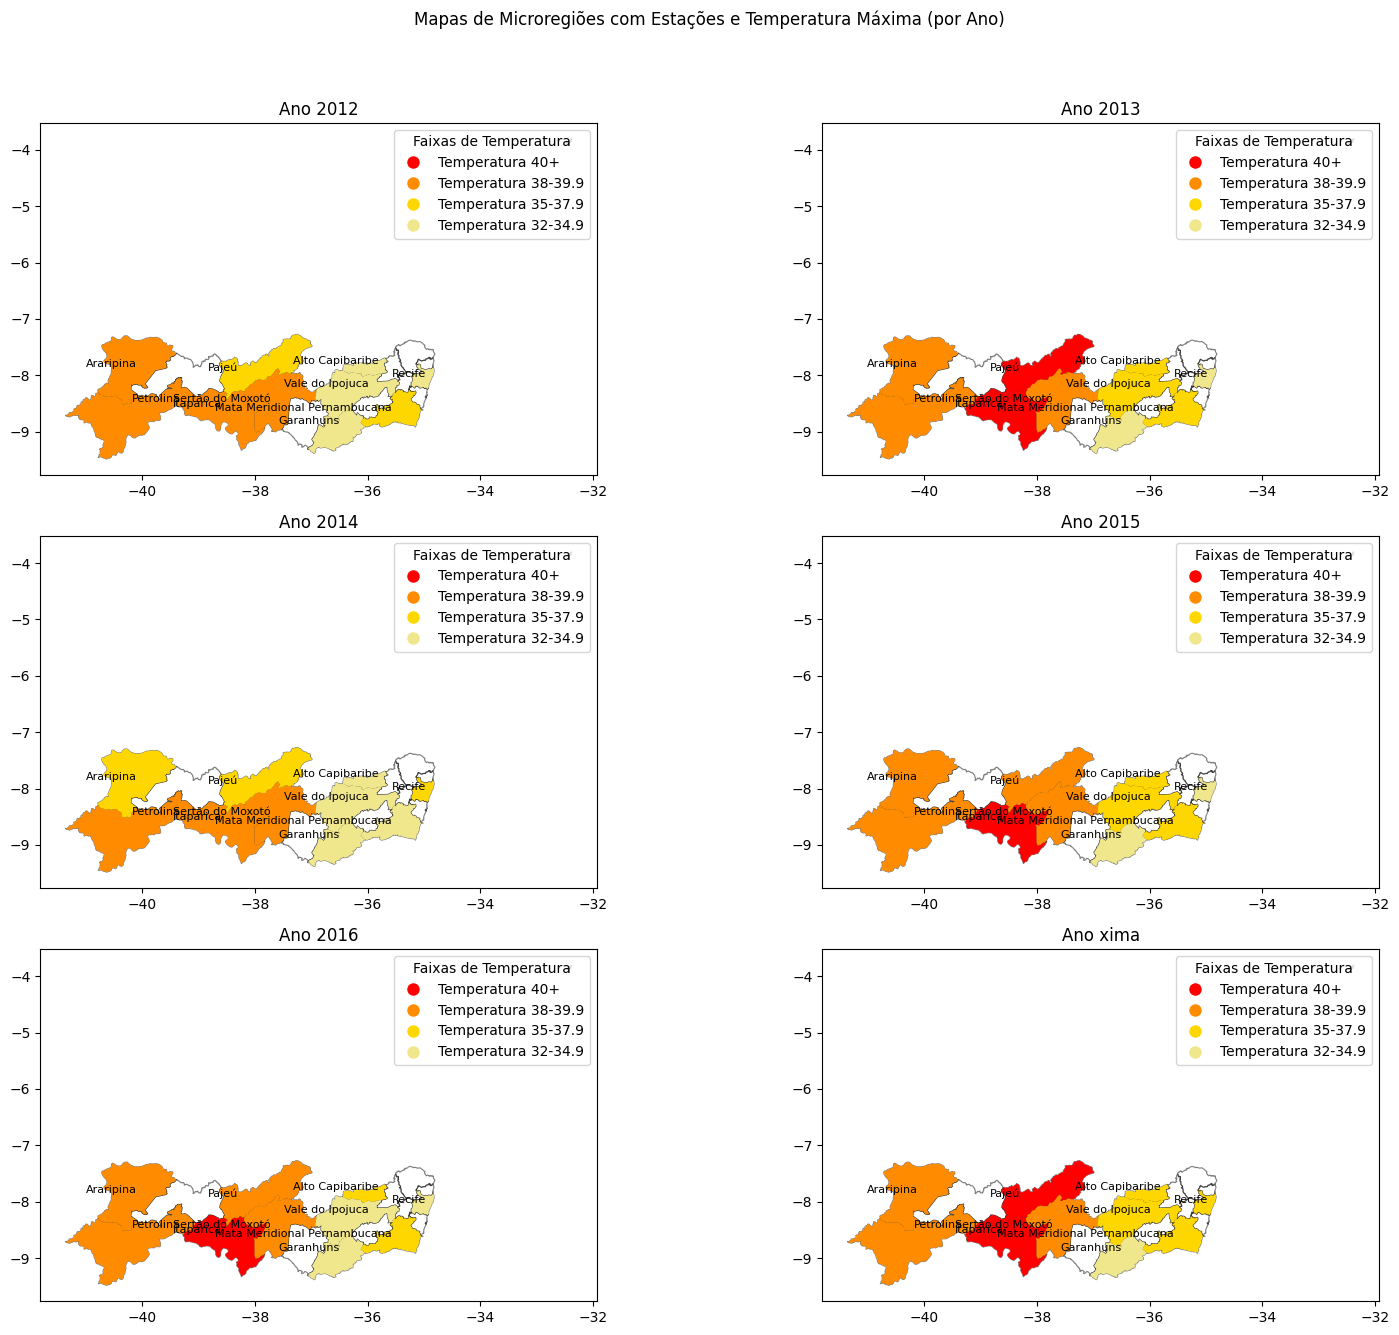

In [43]:
# Lista de anos disponíveis no DataFrame
anos_disponiveis = ['df_2012', 'df_2013', 'df_2014', 'df_2015', 'df_2016', 'Temperatura Máxima']

# Configurações para melhorar a apresentação do mapa
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))
fig.suptitle("Mapas de Microregiões com Estações e Temperatura Máxima (por Ano)")

# Flatten da matriz de subplots para facilitar o acesso
axes = axes.flatten()

for i, ano in enumerate(anos_disponiveis):
    # Plotar o mapa de fundo (microregiões)
    mapa_microregioes.plot(ax=axes[i], edgecolor='black', linewidth=0.8, alpha=0.5, facecolor='none')

    # Definir cores com base nas faixas de temperatura
    colors = {'40+': 'red', '38-39.9': 'darkorange', '35-37.9': 'gold', '32-34.9': 'khaki'}

    # Lista para armazenar objetos de pontos (para a legenda)
    scatter_list = []

    # Plotar os pontos das estações com base na geometria e na faixa de temperatura
    for faixa, color in colors.items():
        if '+' in faixa:
            temp_subset = gdf_temps_maximas_microregioes[gdf_temps_maximas_microregioes[ano] >= float(faixa.replace('+', ''))]
        else:
            temp_range = list(map(float, faixa.split('-')))
            temp_subset = gdf_temps_maximas_microregioes[
                (gdf_temps_maximas_microregioes[ano] >= temp_range[0]) &
                (gdf_temps_maximas_microregioes[ano] <= temp_range[1])
            ]

        scatter = temp_subset.plot(ax=axes[i], color=color, markersize=50, label=f'Temperatura {faixa}', zorder=2)
        scatter_list.append(scatter)

    # Adicionar rótulos para as estações
    for idx, row in gdf_temps_maximas_microregioes.iterrows():
        axes[i].text(row['LONGITUDE:'], row['LATITUDE:'], row['NM_MICRO'], fontsize=8, ha='right', va='bottom', color='black', zorder=3)

    # Adicionar legenda com cores
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Temperatura {faixa}') for faixa, color in colors.items()]
    axes[i].legend(handles=legend_elements, title='Faixas de Temperatura', loc='upper right')  # Mudei aqui para upper right

    # Configurações adicionais
    axes[i].set_title(f'Ano {ano[-4:]}')

# Remover subplots não utilizados
for i in range(len(anos_disponiveis), len(axes)):
    fig.delaxes(axes[i])

# Ajustar o layout para evitar sobreposições
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar os mapas
plt.show()


In [34]:
mapa_mesorregioes = gpd.read_file("./mapa/PE_Mesorregioes_2022/PE_Mesorregioes_2022.shp")
mapa_mesorregioes

,CD_MESO,NM_MESO,SIGLA_UF,AREA_KM2,geometry
0,2601,Sertão Pernambucano,PE,37930.455,"POLYGON ((-37.95776 -7.76623, -37.95770 -7.766..."
1,2602,São Francisco Pernambucano,PE,24443.877,"POLYGON ((-38.91116 -8.33045, -38.90975 -8.328..."
2,2603,Agreste Pernambucano,PE,24512.337,"POLYGON ((-35.57736 -8.43106, -35.57720 -8.430..."
3,2604,Mata Pernambucana,PE,8400.671,"MULTIPOLYGON (((-35.42750 -8.08140, -35.43885 ..."
4,2605,Metropolitana de Recife,PE,2780.538,"MULTIPOLYGON (((-35.02893 -7.93384, -35.02917 ..."


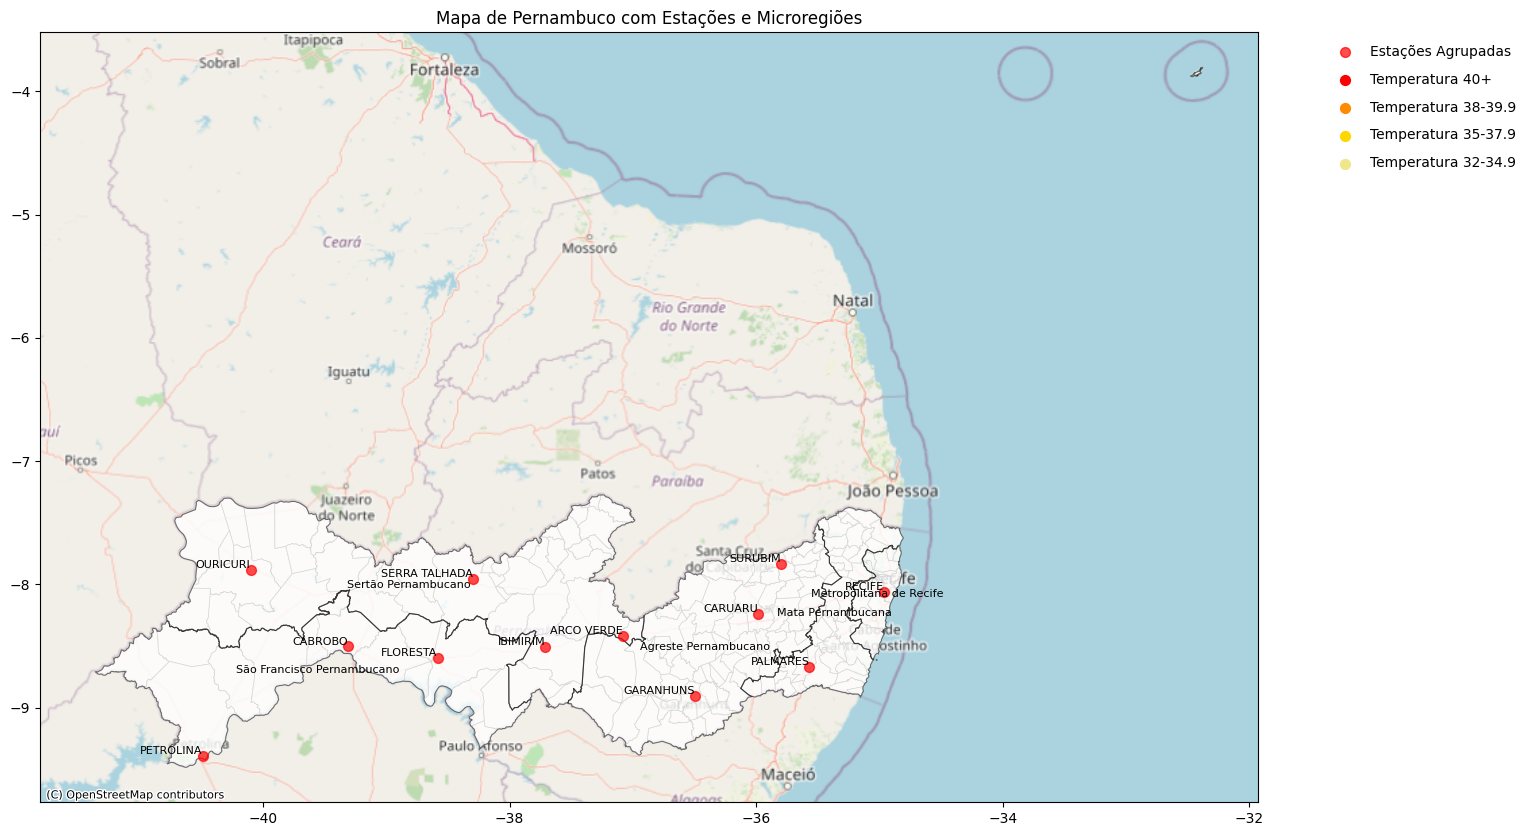

In [35]:
# Carregue o arquivo de dados do mapa de Pernambuco
mapa_pernambuco = gpd.read_file("./mapa/PE_Mnunicipios_2022/PE_Municipios_2022.shp")

nomes_estacoes = df['ESTAÇÃO:'].unique()

# Crie um DataFrame contendo as coordenadas médias para cada estação
coordenadas_estacoes = []
for estacao in nomes_estacoes:
    estacao_data = df[df['ESTAÇÃO:'] == estacao]
    
    # Verifique se existem dados para a estação
    if not estacao_data.empty:
        media_latitude = estacao_data['LATITUDE:'].mean()
        media_longitude = estacao_data['LONGITUDE:'].mean()
        coordenadas_estacoes.append({'Estacao': estacao, 'Latitude': media_latitude, 'Longitude': media_longitude})

# Verifique se há coordenadas para plotar
if coordenadas_estacoes:
    df_estacoes_agrupadas = pd.DataFrame(coordenadas_estacoes)

    # Converta o DataFrame de estações para um GeoDataFrame
    gdf_estacoes_agrupado = gpd.GeoDataFrame(df_estacoes_agrupadas,
                                              geometry=gpd.points_from_xy(df_estacoes_agrupadas['Longitude'], df_estacoes_agrupadas['Latitude']),
                                              crs='EPSG:4326')

    # Carregue o arquivo de dados do mapa de Mesoregiões de Pernambuco
    mapa_mesoregioes = gpd.read_file("./mapa/PE_Mesorregioes_2022/PE_Mesorregioes_2022.shp")

    # Adicione rótulos às geometrias do mapa_mesoregiões
    mapa_mesoregioes['label'] = mapa_mesoregioes['NM_MESO']

    # Alterando o tamanho do mapa
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title("Mapa de Pernambuco com Estações e Microregiões")

    mapa_pernambuco.plot(ax=ax, edgecolor='#D3D3D3', linewidth=0.5, alpha=0.8, color='white')

    # Adicionar fundo de mapa do OpenStreetMap usando contextily
    ctx.add_basemap(ax, crs=mapa_pernambuco.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)

    # Adicionar o mapa de Mesoregiões
    mapa_mesoregioes.plot(ax=ax, edgecolor='black', linewidth=0.8, alpha=0.5, facecolor='none')

    # Adicionar rótulos ao mapa de Mesoregiões
    for x, y, label in zip(mapa_mesoregioes.geometry.centroid.x, mapa_mesoregioes.geometry.centroid.y, mapa_mesoregioes['label']):
        ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black')

    # Adicionar as estações agrupadas ao mapa com símbolo personalizado
    gdf_estacoes_agrupado.plot(ax=ax, marker='o', color='red', markersize=50, label='Estações Agrupadas', alpha=0.7)

    for idx, row in gdf_estacoes_agrupado.iterrows():
        ax.text(row['Longitude'], row['Latitude'], row['Estacao'], fontsize=8, ha='right', va='bottom', color='black')

    # Adicionar legenda ao mapa
    for faixa, cor in colors.items():
        ax.scatter([], [], c=cor, label=f'Temperatura {faixa}', marker='o', s=50)

    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    print("Não há dados de coordenadas para plotar.")


In [36]:
df['ANO'] = pd.to_datetime(df['DATA (YYYY-MM-DD)']).dt.year

tabela_temperaturas_meso = df.pivot_table(values='TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
                                     index='ESTAÇÃO:',
                                     columns='ANO',
                                     aggfunc='max').reset_index()

# Adicionar as colunas 'LATITUDE:' e 'LONGITUDE:' à tabela
tabela_temperaturas_meso[['LATITUDE:', 'LONGITUDE:']] = df.groupby('ESTAÇÃO:')[['LATITUDE:', 'LONGITUDE:']].first().reset_index(drop=True)

tabela_temperaturas_meso.columns = [col if col in ['ESTAÇÃO:', 'LATITUDE:', 'LONGITUDE:'] else f'df_{col}' for col in tabela_temperaturas_meso.columns]

tabela_temperatura_maxima = pd.pivot_table(df, values='TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', index='ESTAÇÃO:', aggfunc='max')

# Renomeie a coluna para evitar conflitos durante a junção
tabela_temperatura_maxima = tabela_temperatura_maxima.rename(columns={'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'Temperatura Máxima'})

# Juntando a tabela de temperatura máxima com as informações das estações
tabela_temperaturas_meso = pd.merge(tabela_temperaturas_meso, tabela_temperatura_maxima, left_on='ESTAÇÃO:', right_index=True, how='left')

print("DataFrame Mestre:")
tabela_temperaturas_meso


DataFrame Mestre:


,ESTAÇÃO:,df_2012,df_2013,df_2014,df_2015,df_2016,LATITUDE:,LONGITUDE:,Temperatura Máxima
0,ARCO VERDE,36.4,36.6,36.0,37.1,37.4,-8.416944,-37.083333,37.4
1,CABROBO,38.3,39.2,38.1,39.7,38.9,-8.503056,-39.313889,39.7
2,CARUARU,34.7,35.3,33.9,35.9,34.8,-8.236111,-35.985833,35.9
3,FLORESTA,39.5,41.2,38.9,41.3,40.5,-8.593611,-38.583889,41.3
4,GARANHUNS,33.4,33.9,32.6,34.7,34.5,-8.906944,-36.494722,34.7
5,IBIMIRIM,38.7,38.7,38.2,39.3,39.4,-8.509444,-37.711389,39.4
6,OURICURI,38.6,38.1,37.8,39.4,39.0,-7.884722,-40.101111,39.4
7,PALMARES,37.7,36.5,34.7,37.2,37.0,-8.666389,-35.568056,37.7
8,PETROLINA,38.0,39.1,38.5,38.6,39.3,-9.388056,-40.489444,39.3
9,RECIFE,34.5,34.1,35.2,33.9,33.8,-8.059167,-34.959444,35.2


In [37]:
# Criando um GeoDataFrame a partir dos dados das estações
gdf_estacoes_meso = gpd.GeoDataFrame(tabela_temperaturas_meso, geometry=gpd.points_from_xy(tabela_temperaturas_meso['LONGITUDE:'], tabela_temperaturas_meso['LATITUDE:']))

# Criando um DataFrame para armazenar as informações de estação por mesoregião
estacoes_por_mesoregiao = pd.DataFrame(columns=['Mesorregiao'])

# Verificando se as estações estão contindas em alguma mesorregião
for idx, mesoregioes in mapa_mesoregioes.iterrows():
    meso_geom = mesoregioes['geometry']
    estacoes_na_meso = gdf_estacoes_meso[gdf_estacoes_meso['geometry'].within(meso_geom)]
    
    # Adicionando informações ao DataFrame estacoes_por_mesoregiao
    estacoes_por_mesoregiao = pd.concat([
        estacoes_por_mesoregiao,
        estacoes_na_meso[['ESTAÇÃO:', 'LATITUDE:', 'LONGITUDE:', 'Temperatura Máxima', 'df_2012','df_2013','df_2014','df_2015','df_2016' ]].assign(Mesorregiao=mesoregioes['NM_MESO'])
    ], ignore_index=True)

# Mostrando o dataframe das mesoregiões com as temperturas máximas de cada ano
estacoes_por_mesoregiao

,Mesorregiao,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima,df_2012,df_2013,df_2014,df_2015,df_2016
0,Sertão Pernambucano,ARCO VERDE,-8.416944,-37.083333,37.4,36.4,36.6,36.0,37.1,37.4
1,Sertão Pernambucano,IBIMIRIM,-8.509444,-37.711389,39.4,38.7,38.7,38.2,39.3,39.4
2,Sertão Pernambucano,OURICURI,-7.884722,-40.101111,39.4,38.6,38.1,37.8,39.4,39.0
3,Sertão Pernambucano,SERRA TALHADA,-7.953611,-38.294722,40.0,37.8,40.0,37.1,38.6,38.0
4,São Francisco Pernambucano,CABROBO,-8.503056,-39.313889,39.7,38.3,39.2,38.1,39.7,38.9
5,São Francisco Pernambucano,FLORESTA,-8.593611,-38.583889,41.3,39.5,41.2,38.9,41.3,40.5
6,São Francisco Pernambucano,PETROLINA,-9.388056,-40.489444,39.3,38.0,39.1,38.5,38.6,39.3
7,Agreste Pernambucano,CARUARU,-8.236111,-35.985833,35.9,34.7,35.3,33.9,35.9,34.8
8,Agreste Pernambucano,GARANHUNS,-8.906944,-36.494722,34.7,33.4,33.9,32.6,34.7,34.5
9,Agreste Pernambucano,SURUBIM,-7.836944,-35.796111,36.1,34.3,35.8,34.5,36.1,35.1


In [38]:
gdf_estacoes_por_mesoregiao = pd.merge(estacoes_por_mesoregiao, mapa_mesoregioes[['NM_MESO', 'geometry']], left_on='Mesorregiao', right_on='NM_MESO')

# Criar um novo GeoDataFrame usando a geometria da microregião
gdf_estacoes_por_mesoregiao = gpd.GeoDataFrame(gdf_estacoes_por_mesoregiao, geometry='geometry', crs=mapa_microregioes.crs)

gdf_estacoes_por_mesoregiao.sort_values(by='Temperatura Máxima', ascending=False)

,Mesorregiao,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima,df_2012,df_2013,df_2014,df_2015,df_2016,NM_MESO,geometry
5,São Francisco Pernambucano,FLORESTA,-8.593611,-38.583889,41.3,39.5,41.2,38.9,41.3,40.5,São Francisco Pernambucano,"POLYGON ((-38.91116 -8.33045, -38.90975 -8.328..."
3,Sertão Pernambucano,SERRA TALHADA,-7.953611,-38.294722,40.0,37.8,40.0,37.1,38.6,38.0,Sertão Pernambucano,"POLYGON ((-37.95776 -7.76623, -37.95770 -7.766..."
4,São Francisco Pernambucano,CABROBO,-8.503056,-39.313889,39.7,38.3,39.2,38.1,39.7,38.9,São Francisco Pernambucano,"POLYGON ((-38.91116 -8.33045, -38.90975 -8.328..."
1,Sertão Pernambucano,IBIMIRIM,-8.509444,-37.711389,39.4,38.7,38.7,38.2,39.3,39.4,Sertão Pernambucano,"POLYGON ((-37.95776 -7.76623, -37.95770 -7.766..."
2,Sertão Pernambucano,OURICURI,-7.884722,-40.101111,39.4,38.6,38.1,37.8,39.4,39.0,Sertão Pernambucano,"POLYGON ((-37.95776 -7.76623, -37.95770 -7.766..."
6,São Francisco Pernambucano,PETROLINA,-9.388056,-40.489444,39.3,38.0,39.1,38.5,38.6,39.3,São Francisco Pernambucano,"POLYGON ((-38.91116 -8.33045, -38.90975 -8.328..."
10,Mata Pernambucana,PALMARES,-8.666389,-35.568056,37.7,37.7,36.5,34.7,37.2,37.0,Mata Pernambucana,"MULTIPOLYGON (((-35.42750 -8.08140, -35.43885 ..."
0,Sertão Pernambucano,ARCO VERDE,-8.416944,-37.083333,37.4,36.4,36.6,36.0,37.1,37.4,Sertão Pernambucano,"POLYGON ((-37.95776 -7.76623, -37.95770 -7.766..."
9,Agreste Pernambucano,SURUBIM,-7.836944,-35.796111,36.1,34.3,35.8,34.5,36.1,35.1,Agreste Pernambucano,"POLYGON ((-35.57736 -8.43106, -35.57720 -8.430..."
7,Agreste Pernambucano,CARUARU,-8.236111,-35.985833,35.9,34.7,35.3,33.9,35.9,34.8,Agreste Pernambucano,"POLYGON ((-35.57736 -8.43106, -35.57720 -8.430..."


In [39]:
# Filtrando os dados para obter apenas as temperaturas máximas de cada mesorregião
indices_max_temps = gdf_estacoes_por_mesoregiao.groupby('NM_MESO')['Temperatura Máxima'].idxmax()

# Criando um DataFrame com os índices encontrados
gdf_temps_maximas_meso = gdf_estacoes_por_mesoregiao.loc[indices_max_temps].copy()

gdf_temps_maximas_meso

,Mesorregiao,ESTAÇÃO:,LATITUDE:,LONGITUDE:,Temperatura Máxima,df_2012,df_2013,df_2014,df_2015,df_2016,NM_MESO,geometry
9,Agreste Pernambucano,SURUBIM,-7.836944,-35.796111,36.1,34.3,35.8,34.5,36.1,35.1,Agreste Pernambucano,"POLYGON ((-35.57736 -8.43106, -35.57720 -8.430..."
10,Mata Pernambucana,PALMARES,-8.666389,-35.568056,37.7,37.7,36.5,34.7,37.2,37.0,Mata Pernambucana,"MULTIPOLYGON (((-35.42750 -8.08140, -35.43885 ..."
11,Metropolitana de Recife,RECIFE,-8.059167,-34.959444,35.2,34.5,34.1,35.2,33.9,33.8,Metropolitana de Recife,"MULTIPOLYGON (((-35.02893 -7.93384, -35.02917 ..."
3,Sertão Pernambucano,SERRA TALHADA,-7.953611,-38.294722,40.0,37.8,40.0,37.1,38.6,38.0,Sertão Pernambucano,"POLYGON ((-37.95776 -7.76623, -37.95770 -7.766..."
5,São Francisco Pernambucano,FLORESTA,-8.593611,-38.583889,41.3,39.5,41.2,38.9,41.3,40.5,São Francisco Pernambucano,"POLYGON ((-38.91116 -8.33045, -38.90975 -8.328..."


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:529: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:529: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:529: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:529: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:529: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.



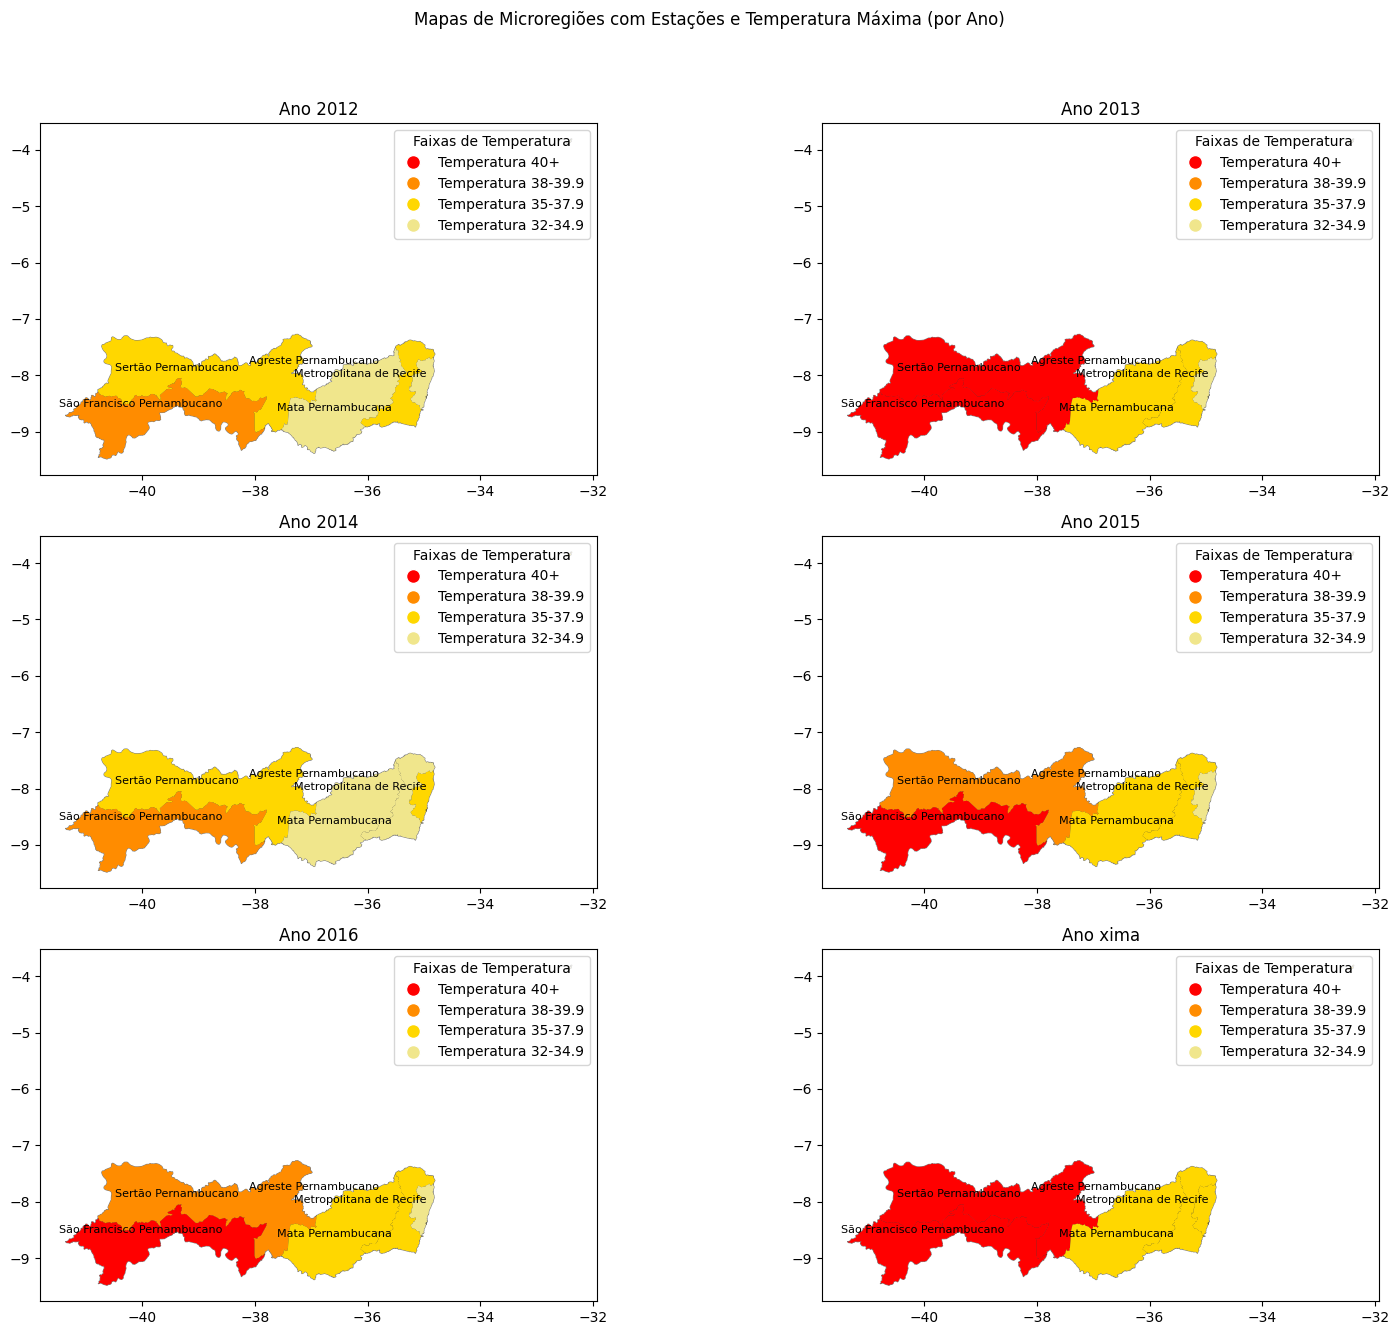

In [40]:
anos_disponiveis = ['df_2012', 'df_2013', 'df_2014', 'df_2015', 'df_2016', 'Temperatura Máxima']

# Configurações para melhorar a apresentação do mapa
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))
fig.suptitle("Mapas de Microregiões com Estações e Temperatura Máxima (por Ano)")

axes = axes.flatten()

for i, ano in enumerate(anos_disponiveis):
    # Plotar o mapa de fundo (mesoregiões)
    mapa_mesoregioes.plot(ax=axes[i], edgecolor='black', linewidth=0.8, alpha=0.5, facecolor='none')

    colors = {'40+': 'red', '38-39.9': 'darkorange', '35-37.9': 'gold', '32-34.9': 'khaki'}

    scatter_list = []

    # Plotando os pontos das estações com base na geometria e na faixa de temperatura
    for faixa, color in colors.items():
        if '+' in faixa:
            temp_subset = gdf_temps_maximas_meso[gdf_temps_maximas_meso[ano] >= float(faixa.replace('+', ''))]
        else:
            temp_range = list(map(float, faixa.split('-')))
            temp_subset = gdf_temps_maximas_meso[
                (gdf_temps_maximas_meso[ano] >= temp_range[0]) &
                (gdf_temps_maximas_meso[ano] <= temp_range[1])
            ]

        scatter = temp_subset.plot(ax=axes[i], color=color, markersize=50, label=f'Temperatura {faixa}', zorder=2)
        scatter_list.append(scatter)

    # Adicionando rótulos para as mesoregiões
    for idx, row in gdf_temps_maximas_meso.iterrows():
        axes[i].text(row['LONGITUDE:'], row['LATITUDE:'], row['Mesorregiao'], fontsize=8, ha='right', va='bottom', color='black', zorder=3)

    # Adicionando legenda com cores
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Temperatura {faixa}') for faixa, color in colors.items()]
    axes[i].legend(handles=legend_elements, title='Faixas de Temperatura', loc='upper right')  # Mudei aqui para upper right

    axes[i].set_title(f'Ano {ano[-4:]}')

for i in range(len(anos_disponiveis), len(axes)):
    fig.delaxes(axes[i])

# Ajustando o layout para evitar sobreposições
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()
